<a href="https://colab.research.google.com/github/eyalgur1/Computer_Vision/blob/main/LoFTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LoFTR (GitHub Repository)

In [66]:
# Clone the GitHub repository
!git clone https://github.com/zju3dv/LoFTR.git
%cd LoFTR

# import os  # Imports the os module for interacting with the operating system.
# os.chdir("LoFTR")  # Changes the current working directory to the parent directory. This ensures that relative paths used in the code are accessible.

from google.colab import drive
drive.mount("/content/drive/")

!pip install kornia
!pip install yacs

Cloning into 'LoFTR'...
remote: Enumerating objects: 416, done.
remote: Total 416 (delta 0), reused 0 (delta 0), pack-reused 416 (from 1)
Receiving objects: 100% (416/416), 30.81 MiB | 23.81 MiB/s, done.
Resolving deltas: 100% (159/159), done.
/content/LoFTR/LoFTR
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [67]:
# Create the (old) weights directory and download the checkpoint
!mkdir -p weights
!wget -O weights/indoor_ds.ckpt http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_indoor.ckpt  # Dual-softmax
!wget -O weights/outdoor_ds.ckpt http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt  # Dual-softmax

--2024-12-17 15:10:40--  http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_indoor.ckpt
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46336731 (44M)
Saving to: ‘weights/indoor_ds.ckpt’

weights/indoor_ds.c 100%[===================>]  44.19M  20.8MB/s    in 2.1s    

2024-12-17 15:10:43 (20.8 MB/s) - ‘weights/indoor_ds.ckpt’ saved [46336731/46336731]

--2024-12-17 15:10:43--  http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46341978 (44M)
Saving to: ‘weights/outdoor_ds.ckpt’

weights/outdoor_ds. 100%[===================>]  44.19M  20.4MB/s    in 2.2s    

2024-12-17 15:10:45 (20.4 MB/s) - ‘weights/outdoor_ds.ckpt’ saved [46341978/46341978]


In [68]:
from copy import deepcopy

import torch
import kornia
import yacs
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

In [69]:
from src.loftr import LoFTR, default_cfg

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
_default_cfg = deepcopy(default_cfg)
_default_cfg['coarse']['temp_bug_fix'] = False  # set to False when using the old ckpt
# Setting this to True fixes compatibility with newer model checkpoints.

#### Image 1 (Indoors)

In [ ]:
# Instantiates the LoFTR model with the specified configuration.
matcher = LoFTR(config=_default_cfg)

# Loads the pretrained weights for LoFTR from a checkpoint file
matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])  # ['state_dict']: Extracts the model weights from the checkpoint.
matcher = matcher.eval().to(device)  # Switches the model to evaluation mode (disables dropout, batch normalization updates, etc.).

# Load example images
img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"

img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)  # cv2 loads as NumPy
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))  # Resizes both images to 640×480 resolution to ensure uniform input dimensions.
img1_raw = cv2.resize(img1_raw, (640, 480))
print(img0_raw.shape)

img0 = torch.from_numpy(img0_raw)[None][None].to(device) / 255.
img1 = torch.from_numpy(img1_raw)[None][None].to(device) / 255.
# Converts the NumPy arrays (images) into PyTorch tensors.
# [None][None]: Adds two singleton dimensions at the begining:
    # The first dimension corresponds to the batch size.
    # The second corresponds to the number of channels (grayscale → 1 channel).
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():  # Disables gradient calculation to reduce memory usage and speed up inference.
    # Runs the LoFTR model on the input images, modifying the batch dictionary to include:
        # mkpts0_f: Matched keypoints in image 0.
        # mkpts1_f: Matched keypoints in image 1.
        # mconf: Confidence scores for each match.
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()  # move to numpy for visualization
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

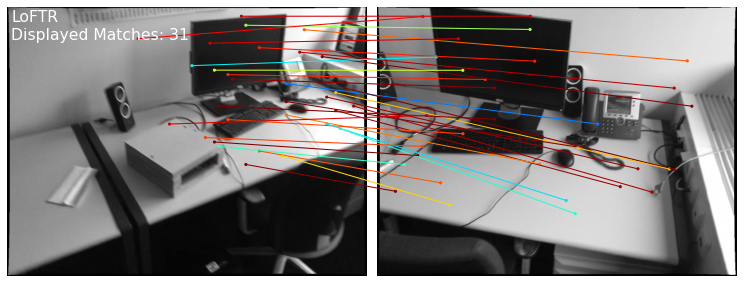

In [101]:
# Draw
color = cm.jet(mconf)  # Maps the confidence scores (mconf) to colors using the "jet" colormap
match_to_draw = len(mkpts0)//30
text = [
    'LoFTR',
    'Displayed Matches: {}'.format(len(mkpts0[::match_to_draw]))]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0[::match_to_draw], mkpts1[::match_to_draw], color[::match_to_draw], text=text)

#### Image 2 (Outdoors)

In [ ]:
matcher = LoFTR(config=_default_cfg)
matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().to(device)

# Load example images
img0_pth = "/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/road.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)

# Define crop region: [y1:y2, x1:x2]
crop_y1, crop_y2 = 20, 400  # Crop height range
crop_x1, crop_x2 = 20, 500  # Crop width range

# Crop the image
img1_cropped = img0_raw[crop_y1:crop_y2, crop_x1:crop_x2]

# Get the image center
(h, w) = img1_cropped.shape
center = (w // 2, h // 2)

# Define the rotation matrix
angle = 20  # Rotation angle in degrees (positive = counterclockwise)
scale = 1.0  # Scale factor
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

# Rotate the image
img1_raw = cv2.warpAffine(img1_cropped, rotation_matrix, (w, h))

img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].to(device) / 255.
img1 = torch.from_numpy(img1_raw)[None][None].to(device) / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

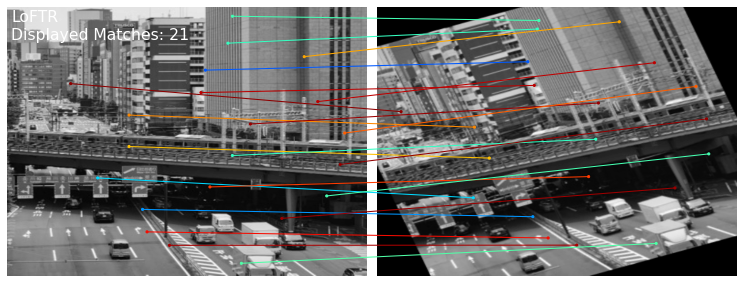

In [91]:
# Draw
color = cm.jet(mconf)
match_to_draw = len(mkpts0)//20
text = [
    'LoFTR',
    'Displayed Matches: {}'.format(len(mkpts0[::match_to_draw]))]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0[::match_to_draw], mkpts1[::match_to_draw], color[::match_to_draw], text=text)

In [79]:
aa = np.linspace(0,10)
print(aa[0:10:4])

[0.         0.81632653 1.63265306]


## LoFTR (Kornia)

In [105]:
import kornia as K
import matplotlib.pyplot as plt
import numpy as np
import kornia.feature as KF
from kornia.feature import LoFTR

!pip install kornia  kornia-rs  kornia_moons opencv-python --upgrade
from kornia_moons.viz import draw_LAF_matches

#### Image 1 (Indoors)

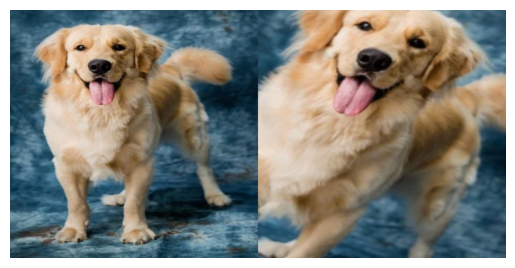

In [106]:
img1 = K.io.load_image('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/dog.PNG', K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/dog_crop.PNG', K.io.ImageLoadType.RGB32)[None, ...]

# the [None, ...] at the end specifies to add another dimension at the beginning of the tensor; this is equivalent to [None, :, :, :], but we might not have the knowledge of how many dimensions already exist
# the added dimension is required for LoFTR matcher

# rescale the two images into the same size
img1 = K.geometry.resize(img1, (512, 512), antialias=True)  # antialias=True means that the image will be filtered with Gaussian if downscaling
img2 = K.geometry.resize(img2, (512, 512), antialias=True)


# to display a kornia image (which is a PyTorch tensor), we must convert it into NumPy
# if we want to display the image with its RGB, we discard the new first dimension, and then permute to shape (H,W,3) with 3 RGB channels at the end
image_np1 = img1[0,:].permute(1,2,0).numpy();  image_np2 = img2[0,:].permute(1,2,0).numpy()

# display the original (scaled) images
plt.imshow(np.hstack((image_np1, image_np2)))
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [107]:
"Module which finds correspondences between two images"
matcher = LoFTR(pretrained="indoor")
# pretrained argument: download and set pretrained weights to the model.
# Options: ‘outdoor’ and ‘indoor’, where ‘outdoor’ is trained on the MegaDepth dataset and ‘indoor’ on the ScanNet.

In [108]:
"Find matching keypoints using a trained LoFTR matcher"
# the LoFTR mathcer only works with grayscale images
input_dict = {"image0": K.color.rgb_to_grayscale(img1), "image1": K.color.rgb_to_grayscale(img2)}
with torch.inference_mode():
    correspondences = matcher(input_dict)

print(correspondences)

# 'correspondences' is a dictionary containing the coordinates of the keypoints in each image in items "keypoints0" and "keypoints1",
# the confidence score of each match (see the confidence matrix in the document), and batch_indexes if applicable

{'keypoints0': tensor([[304.,  24.],
        [248.,  32.],
        [280.,  32.],
        ...,
        [272., 376.],
        [192., 384.],
        [200., 384.]]), 'keypoints1': tensor([[480.1731,  31.7484],
        [399.6642,  15.7296],
        [439.5152,  32.0375],
        ...,
        [128.6622, 488.8339],
        [ 16.0524, 464.5978],
        [ 24.2961, 472.1600]]), 'confidence': tensor([0.4912, 0.9934, 0.9877,  ..., 0.4552, 0.8946, 1.0000]), 'batch_indexes': tensor([0, 0, 0,  ..., 0, 0, 0])}


In [109]:
"Further clean the matching using RANSAC and display the matchings"
mkpts0 = correspondences["keypoints0"].numpy()  # convert the coordinate keypoint tensors into NumPy
mkpts1 = correspondences["keypoints1"].numpy()

# to clear up outlier matches, we take the two sets of keypoints, and estimate their Fundamental Matrix, which is viewd here as a fitting model of the matches
# by applying RANSAC (more specifically, its variant USAC_MAGSAC) for the Fundamental Matrix fitting model, we clean ouliers
# the value 0.5 is the threshold for considering a point to be an inlier
# the value 0.999 is the confidence level that the estimated Fundamental Matrix (fitter) is correct
# the value 100000 is the number of RANSAC iterations
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)

# the 'inliers' set is a numpy array with entries 0=outlier and 1=inlier
inliers = inliers > 0  # converting the 0,1 to False,True as we only want to stay with the indices of the (robust) inliers

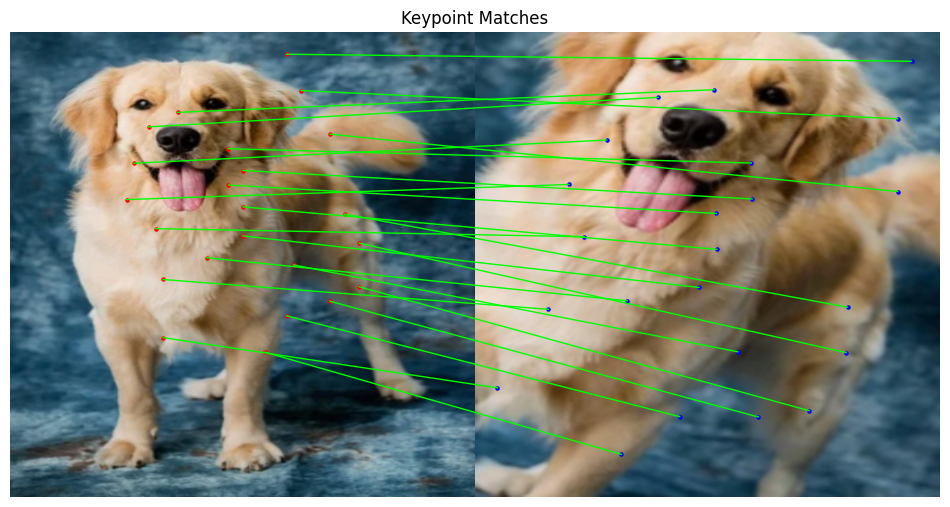

In [111]:
# Display the inlier matches after RANSAC filtering
def plot_matches(img1, img2, mkpts0, mkpts1, inliers, num_matches=-1):
    """
    Plot keypoint matches between two images after RANSAC filtering.

    Args:
        img1: First image (tensor, range [0, 1]).
        img2: Second image (tensor, range [0, 1]).
        mkpts0: Keypoints in the first image (NumPy array of shape [N, 2]).
        mkpts1: Keypoints in the second image (NumPy array of shape [N, 2]).
        inliers: Boolean mask indicating inliers (NumPy array of shape [N, 1]).
        num_matches: Number of matches to display (-1 for all).
    """
    # Convert images to NumPy and scale to [0, 255]
    img1_np = (K.tensor_to_image(img1) * 255).astype(np.uint8)  # Convert to uint8
    img2_np = (K.tensor_to_image(img2) * 255).astype(np.uint8)

    # Filter the matches using the inliers mask
    mkpts0_inliers = mkpts0[inliers.flatten()]
    mkpts1_inliers = mkpts1[inliers.flatten()]

    # Limit the number of matches displayed
    if num_matches > 0:
        mkpts0_inliers = mkpts0_inliers[::num_matches]
        mkpts1_inliers = mkpts1_inliers[::num_matches]

    # Stack the images horizontally
    h1, w1 = img1_np.shape[:2]
    h2, w2 = img2_np.shape[:2]
    combined_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    combined_img[:h1, :w1] = img1_np  # Place first image
    combined_img[:h2, w1:] = img2_np  # Place second image

    # Plot the matches
    plt.figure(figsize=(12, 8))
    plt.imshow(combined_img)
    plt.axis("off")
    plt.title("Keypoint Matches")

    # Draw the matches as lines
    for pt0, pt1 in zip(mkpts0_inliers, mkpts1_inliers):
        x0, y0 = pt0
        x1, y1 = pt1
        x1 += w1  # Offset x-coordinate for the second image
        plt.plot([x0, x1], [y0, y1], c="lime", lw=1)
        plt.scatter(x0, y0, c="red", s=5)  # Keypoint in first image
        plt.scatter(x1, y1, c="blue", s=5)  # Keypoint in second image

    plt.show()

# Call the function to plot matches
plot_matches(img1, img2, mkpts0, mkpts1, inliers, num_matches=30)


#### Image 2 (Outdoors)

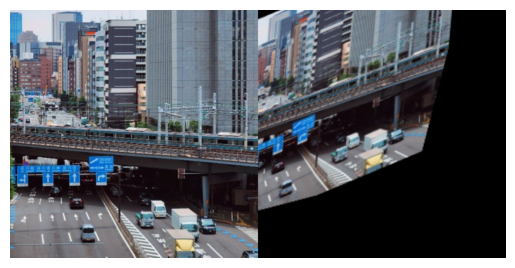

In [119]:
img1 = K.io.load_image('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/road.jpg', K.io.ImageLoadType.RGB32)[None, ...]
# the [None, ...] at the end specifies to add another dimension at the beginning of the tensor; this is equivalent to [None, :, :, :], but we might not have the knowledge of hoe many dimensions already exist
# the added dimension is required for LoFTR matcher

# Rotate the image
angle = torch.tensor([10.0])  # Rotate by 30 degrees
img_rotated = K.geometry.transform.rotate(img1, angle)

# Crop the rotated image
# Crop parameters: (top-left y, top-left x, height, width)
crop_params = torch.tensor([[[10, 10], [356, 100], [356, 356], [100, 356]]], dtype=torch.float32)  # Adjust as needed: crop region size 256x256
img2 = K.geometry.transform.crop_and_resize(img_rotated, crop_params, size=(256, 256))

# rescale the two images into the same size
img1 = K.geometry.resize(img1, (512, 512), antialias=True)  # antialias=True means that the image will be filtered with Gaussian if downscaling
img2 = K.geometry.resize(img2, (512, 512), antialias=True)


# to display a kornia image (which is a PyTorch tensor), we must convert it into NumPy
# if we want to display the image with its RGB, we discard the new first dimension, and then permute to shape (H,W,3) with 3 RGB chanels at the end
image_np1 = img1[0,:].permute(1,2,0).numpy();  image_np2 = img2[0,:].permute(1,2,0).numpy()

# display the original (scaled) images
plt.imshow(np.hstack((image_np1, image_np2)))
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [120]:
"Module which finds correspondences between two images"
matcher = LoFTR(pretrained="outdoor")
# pretrained argument: download and set pretrained weights to the model.
# Options: ‘outdoor’ and ‘indoor’, where ‘outdoor’ is trained on the MegaDepth dataset and ‘indoor’ on the ScanNet.

In [121]:
"Find matching keypoints using a trained LoFTR matcher"
# the LoFTR mathcer only works with grayscale images
input_dict = {"image0": K.color.rgb_to_grayscale(img1), "image1": K.color.rgb_to_grayscale(img2)}
with torch.inference_mode():
    correspondences = matcher(input_dict)

# 'correspondences' is a dictionary containing the coordinates of the keypoints in each image in items "keypoints0" and "keypoints1",
# the confidence score of each match (see the confidence matrix in the document), and batch_indexes of applicable

In [126]:
"Further clean the matching using RANSAC and display the matchings"
mkpts0 = correspondences["keypoints0"].numpy()  # convert the coordinate keypoint tensors into NumPy
mkpts1 = correspondences["keypoints1"].numpy()

# to clear up outlier matches, we take the two sets of keypoints, and estimate their Fundamental Matrix, which is viewd here as a fitting model of the matches
# by applying RANSAC (more specifically, its variant USAC_MAGSAC) for the Fundamental Matrix fitting model, we clean ouliers
# the value 0.5 is the threshold for considering a point to be an inlier
# the value 0.999 is the confidence level that the estimated Fundamental Matrix (fitter) is correct
# the value 100000 is the number of RANSAC iterations
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)

# the 'inliers' set is a numpy array with entries 0=outlier and 1=inlier
inliers = inliers > 0  # converting the 0,1 to False,True as we only want to stay with the indices of the (robust) inliers

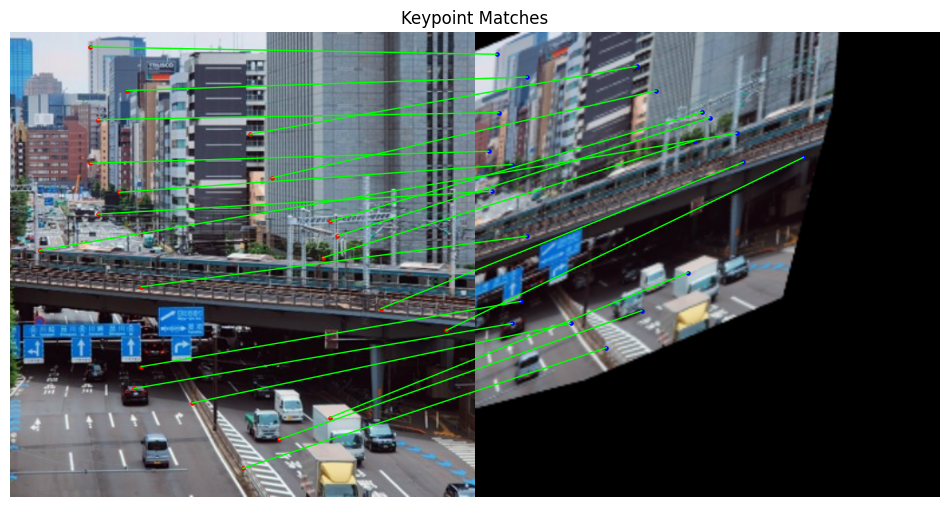

In [127]:
# Display the inlier matches after RANSAC filtering
def plot_matches(img1, img2, mkpts0, mkpts1, inliers, num_matches=-1):
    """
    Plot keypoint matches between two images after RANSAC filtering.

    Args:
        img1: First image (tensor, range [0, 1]).
        img2: Second image (tensor, range [0, 1]).
        mkpts0: Keypoints in the first image (NumPy array of shape [N, 2]).
        mkpts1: Keypoints in the second image (NumPy array of shape [N, 2]).
        inliers: Boolean mask indicating inliers (NumPy array of shape [N, 1]).
        num_matches: Number of matches to display (-1 for all).
    """
    # Convert images to NumPy and scale to [0, 255]
    img1_np = (K.tensor_to_image(img1) * 255).astype(np.uint8)  # Convert to uint8
    img2_np = (K.tensor_to_image(img2) * 255).astype(np.uint8)

    # Filter the matches using the inliers mask
    mkpts0_inliers = mkpts0#[inliers.flatten()]
    mkpts1_inliers = mkpts1#[inliers.flatten()]

    # Limit the number of matches displayed
    if num_matches > 0:
        mkpts0_inliers = mkpts0_inliers[::num_matches]
        mkpts1_inliers = mkpts1_inliers[::num_matches]

    # Stack the images horizontally
    h1, w1 = img1_np.shape[:2]
    h2, w2 = img2_np.shape[:2]
    combined_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    combined_img[:h1, :w1] = img1_np  # Place first image
    combined_img[:h2, w1:] = img2_np  # Place second image

    # Plot the matches
    plt.figure(figsize=(12, 8))
    plt.imshow(combined_img)
    plt.axis("off")
    plt.title("Keypoint Matches")

    # Draw the matches as lines
    for pt0, pt1 in zip(mkpts0_inliers, mkpts1_inliers):
        x0, y0 = pt0
        x1, y1 = pt1
        x1 += w1  # Offset x-coordinate for the second image
        plt.plot([x0, x1], [y0, y1], c="lime", lw=1)
        plt.scatter(x0, y0, c="red", s=5)  # Keypoint in first image
        plt.scatter(x1, y1, c="blue", s=5)  # Keypoint in second image

    plt.show()

# Call the function to plot matches
plot_matches(img1, img2, mkpts0, mkpts1, inliers, num_matches=40)
